## FIFA 2018 World Predictions Using Machine Learning

#### We will conduct this analysis in three parts:

**Part 1:** Conducting exploratory analysis of individual teams

**Part 2:** Selecting the appropriate labels and features for our machine learning model

**Part 3:** Using our labels and features to forecast the match winners in the 2018 World Cup

#### Datasets required

Participating Teams Record: https://www.kaggle.com/ahmedelnaggar/fifa-worldcup-2018-dataset

International Football Match Results: https://www.kaggle.com/martj42/international-football-results-from-1872-to-2017/data

International Mens Team Football Rankings: https://us.soccerway.com/teams/rankings/fifa/?ICID=TN_03_05_01

FIFA World Cup 2018 Fixtures and Results: https://fixturedownload.com/results/fifa-world-cup-2018

## Data Analysis

### Exporting the Modules



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.ticker as plticker
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
sns.set()

world_cup = pd.read_csv('World Cup 2018 Dataset.csv')
results = pd.read_csv('results.csv')

#### Column Features

The `world_cup` and `results` variable outlines the columns listed in the dataset. Some of these columns will be used, while others are irrelevant for our analysis. 

In [2]:
world_cup.head()
results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland
1,1873-03-08,England,Scotland,4,2,Friendly,London,England
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland
3,1875-03-06,England,Scotland,2,2,Friendly,London,England
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland


#### Goal Difference and Establishing the Winner

The `results` dataset shows all FIFA matches since 1872, as well as the location and the outcome. However, for the algorithm's purpose, it is unable to distinguish between winner and loser. We need a way for use to be able to tell the algorithm who was the winner or loser of each match (if there were winners/losers).

We also need to determine the goal differential (we will explain later).

In [3]:
#Adding goal difference and establishing who is the winner 
winner = []
for i in range (len(results['home_team'])):
    if results ['home_score'][i] > results['away_score'][i]:
        winner.append(results['home_team'][i])
    elif results['home_score'][i] < results ['away_score'][i]:
        winner.append(results['away_team'][i])
    else:
        winner.append('Draw')
results['winning_team'] = winner

#adding goal difference column
results['goal_difference'] = np.absolute(results['home_score'] - results['away_score'])

results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,winning_team,goal_difference
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,Draw,0
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,England,2
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,Scotland,1
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,Draw,0
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,Scotland,3


We want to work with a data that includes games played by a participating team. I wanted to analyze the US Mens National Team, but unforunately, they were eliminated by Trinidad & Tobago in the qualifying rounds.

The Danish Mens National Team (NKVD) was also eliminated by The Swedish Mens National Team. Because of this, I have chosen to analyze the German Mens National Team.

In [4]:
df = results[(results['home_team'] == 'Germany') | (results['away_team'] == 'Germany')]
germany = df.iloc[:]
germany.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,winning_team,goal_difference
209,1908-04-05,Switzerland,Germany,5,3,Friendly,Basel,Switzerland,Switzerland,2
216,1908-06-07,Austria,Germany,3,2,Friendly,Vienna,Austria,Austria,1
234,1909-04-04,Germany,Switzerland,1,0,Friendly,Karlsruhe,Germany,Germany,1
235,1909-04-04,Hungary,Germany,3,3,Friendly,Budapest,Hungary,Draw,0
253,1910-04-03,Switzerland,Germany,2,3,Friendly,Basel,Switzerland,Germany,1


Now we have the matches which only contain the German Mens National Team. However, we're only interested in analzing matches that occured during the World Cup era. The first world cup took place in 1930. As such, we will only look at matches that took place after 1930.

In [5]:
year = []
for row in germany['date']:
    year.append(int(row[:4]))
germany['match_year'] = year
germany_1930 = germany[germany.match_year >= 1930]
germany_1930.count()

date               863
home_team          863
away_team          863
home_score         863
away_score         863
tournament         863
city               863
country            863
winning_team       863
goal_difference    863
match_year         863
dtype: int64

We have 863 recorded matches for the German Mens National Football Team. We can now visualize the most common outcome for the Germany throughout the years.

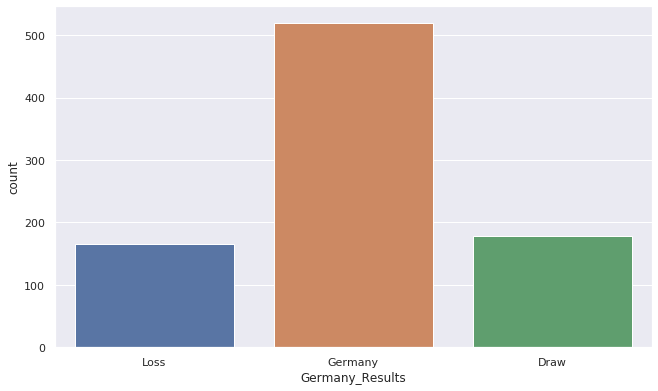

In [6]:
wins = []
for row in germany_1930['winning_team']:
    if row != 'Germany' and row != 'Draw':
        wins.append('Loss')
    else:
        wins.append(row)
winsdf = pd.DataFrame(wins, columns = ['Germany_Results'])

fig, ax = plt.subplots(1)
fig.set_size_inches(10.7,6.27)
sns.set(style = 'darkgrid')
sns.countplot(x = 'Germany_Results', data=winsdf)

The win rate is a good metric to analyze and predict outcomes of matches in the tournament. The venues; however, won't add much value to our predictions. We can use historical match records to aid our analysis.

For now, we must list the participating teams in the 2018 World Cup. The teams are outlined in the following groups:

**Group A:** Uruguay, Russia, Saudi Arabia, Egypt
<br>**Group B:** Spain, Portugal, Iran, Morocco
<br>**Group C:** France, Denmark, Peru, Australia
<br>**Group D:** Croatia, Argentina, Nigeria, Iceland
<br>**Group E:** Brazil, Switzerland, Serbia, Costa Rica
<br>**Group F:** Sweden, Mexico, South Korea, Germany
<br>**Group G:** Belgium, England, Tunisia, Panama
<br>**Group H:** Columbia, Japan, Senegal, Poland

With these groups, we need to create a dataframe that shows only teams in this year's world up from 1930 onwards as well as drop duplicates. We also need to create a year column and drop games before the year 1930, as well as columns that won't affect match outcome for example date, home_score, away_score, tournament, city, country, goal_difference, and match_year.

In [7]:
worldcup_teams = ['Australia', 'Iran', 'Japan', 'Korea Republic',
                  'Saudi Arabia', 'Egypt', 'Morocco', 'Nigeria',
                  'Senegal', 'Tunisia', 'Costa Rica', 'Mexico',
                  'Panama', 'Argentina', 'Brazil', 'Colombia',
                  'Peru', 'Uruguay', 'Belgium', 'Croatia',
                  'Denmark', 'England', 'France', 'Germany',
                  'Iceland', 'Poland', 'Portugal', 'Russia',
                  'Serbia', 'Spain', 'Sweden', 'Switzerland']

df_teams_home = results[results['home_team'].isin(worldcup_teams)]
df_teams_away = results[results['away_team'].isin(worldcup_teams)]
df_teams = pd.concat((df_teams_home, df_teams_away))
df_teams.drop_duplicates()
df_teams.count()

year = []
for row in df_teams['date']:
    year.append(int(row[:4]))
df_teams['match_year'] = year
df_teams_1930 = df_teams[df_teams.match_year >= 1930]
df_teams_1930.head()

df_teams_1930 = df_teams.drop(['date', 'home_score', 'away_score', 'tournament', 'city', 'country',
                               'goal_difference', 'match_year'], axis = 1)

df_teams_1930.head()

,home_team,away_team,winning_team
1,England,Scotland,England
3,England,Scotland,Draw
6,England,Scotland,Scotland
10,England,Wales,England
11,England,Scotland,England


## Building The Model

We need to establish the prediction labels for our model. Our prediction label will be the winning_team column, which will show "2" if the home team has won, "1" if the match results in a draw, and "0" if the away team has won.

In [8]:
df_teams_1930 = df_teams_1930.reset_index(drop=True)
df_teams_1930.loc[df_teams_1930.winning_team == df_teams_1930.home_team,'winning_team']=2
df_teams_1930.loc[df_teams_1930.winning_team == 'Draw', 'winning_team']=1
df_teams_1930.loc[df_teams_1930.winning_team == df_teams_1930.away_team, 'winning_team']=0

df_teams_1930.head()

,home_team,away_team,winning_team
0,England,Scotland,2
1,England,Scotland,1
2,England,Scotland,0
3,England,Wales,2
4,England,Scotland,2


Next, we convert the home_team and away_team columns from categorical variables to continous variables. By using the `pd.get_dummies()` function, we can assign dummy variables to the categorical variables.

We we separate the labels and features, the `train_test_split` function will split the data into 70 percent training and 30 percetn testing.

In [9]:
final = pd.get_dummies(df_teams_1930, prefix=['home_team', 'away_team'], columns=['home_team', 'away_team'])

# Separate X and y sets
X = final.drop(['winning_team'], axis=1)
y = final["winning_team"]
y = y.astype('int')

# Separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [10]:
final.head()

,winning_team,home_team_Afghanistan,home_team_Albania,home_team_Algeria,home_team_Andorra,home_team_Angola,home_team_Argentina,home_team_Armenia,home_team_Aruba,home_team_Australia,...,away_team_Venezuela,away_team_Vietnam,away_team_Vietnam Republic,away_team_Wales,away_team_Western Australia,away_team_Yemen,away_team_Yemen DPR,away_team_Yugoslavia,away_team_Zambia,away_team_Zimbabwe
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Logistic Regression

The Scikit-learn package allows us to use machine learning packages such as Linear Regression. The only problem is that we can’t use linear regression on a categorical dependent variable. Instead, in such situations, we should try using algorithms such as Logistic Regression.

Logistic regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 for success or 0 for failure. In other words, the logistic regression model predicts P(Y=1) as a function of X.

![Logistic Regression >](https://kidquant.com/post/images/logistic_regression.jpg)

Logistic regression is one of the most popular ways to fit models for categorical data, especially for binary response data in Data Modeling. It is the most important (and probably the most used) member of a class of models called generalized linear models. Unlike linear regression, logistic regression can directly predict probabilities (values that are restricted to the (0,1) interval).

Logistic Regression is used when the dependent variable (target) is categorical. For example:

* To predict whether an email is spam (1) or not spam (0)
* Whether a company is a bankrupt (1) or not bankrupt (0)

Logistic regression is generally used where the dependent variable is Binary or Dichotomous. That means the dependent variable can take only two possible values, such as “Yes” or “No,” “Default” or “No Default,” “Living” or “Dead,” etc. Independent factors or variables can be categorical or numerical variables.

In our case, logistic regression attempts to predict an outcome (a win or loss) given a set of data points (stats) that likely influence that outcome. The way this works in practice is you feed the algorithm one game at a time, with both the aforementioned “set of data” and the actual outcome of the match. The model then learns how each piece of data you feed it influences the result of the game positively, negatively, and to what extent.

#### Machine Learning: Match Prediction

In [ ]:
final.head()
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
score = logreg.score(X_train, y_train)
score2 = logreg.score(X_test, y_test)

print('Training set accuracy ', '%.3f'%(score))
print('Test set accuracy ', '%.3f'%(score2))

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Passing our features and labels into our algorithm, we recieved a training set accuracy of 0.571 and a testing set accuracy of 0.564, which isn’t the greatest, but we will continue to use these features. At this point, we will create a dataframe that we will deploy out model.

FIFA ranking as of April 2018 data set and a dataset containing the fixtures of the group stages of the tournament. The team which is positioned higher on the FIFA Ranking will be considered the “favorite” of the match, and therefore, will be positioned under the “home_teams” column, since obviously the only home team in this world cup is Russia. We will then add teams to the new prediction dataset based on the ranking position of each team. The next step will be to create dummy variables and then deploy the machine learning model.

In [ ]:
# Loading new datasets
fixtures = pd.read_csv('fixtures.csv')
ranking = pd.read_csv('fifa_rankings.csv', encoding = 'latin-1')

# List for storing the group stage games
pred_set = []

# Create new columns with ranking position of each team
fixtures.insert(1, 'first_position', fixtures['Home Team'].map(ranking.set_index('Team')['Position']))
fixtures.insert(2, 'second_position', fixtures['Away Team'].map(ranking.set_index('Team')['Position']))

# We only need the group stage games, so we have to slice the dataset
fixtures = fixtures.iloc[:48, :]
fixtures.tail()

In [ ]:
# Loop to add teams to new prediction dataset based on the ranking position of each team
for index, row in fixtures.iterrows():
    if row['first_position'] < row['second_position']:
        pred_set.append({'home_team': row['Home Team'], 'away_team': row['Away Team'], 'winning_team': None})
    else:
        pred_set.append({'home_team': row['Away Team'], 'away_team': row['Home Team'], 'winning_team': None})
        
pred_set = pd.DataFrame(pred_set)
backup_pred_set = pred_set

pred_set.head()

In [ ]:
# Get dummy variables and drop winning_team column
pred_set = pd.get_dummies(pred_set, prefix=['home_team', 'away_team'], columns=['home_team', 'away_team'])

# Add missing columns compared to the model's training dataset
missing_cols = set(final.columns) - set(pred_set.columns)
for c in missing_cols:
    pred_set[c] = 0
pred_set = pred_set[final.columns]

# Remove winning team column
pred_set = pred_set.drop(['winning_team'], axis=1)

pred_set.head()

Now we have all of our features, we can create a for loop that allows us to predict the winner based on our preferred parameters.

In [ ]:
predictions = logreg.predict(pred_set)
for i in range(fixtures.shape[0]):
    print(backup_pred_set.iloc[i, 1] + ' and ' + backup_pred_set.iloc[i, 0])
    if predictions[i] == 2:
        print('Winner: ' + backup_pred_set.iloc[i, 1])
    elif predictions[i] == 1:
        print('Draw')
    elif predictions[i] == 0:
        print('Winner: ' + backup_pred_set.iloc[i, 0])
    print('Probability of Draw: ', '%.3f'%(logreg.predict_proba(pred_set)[i][1]))
    print('Probability of ' + backup_pred_set.iloc[i,0] + ' winning: ', '%.3f'%(logreg.predict_proba(pred_set)[i][0]))
    print('')

Based on this information, it looks like the former champions will be making it out of the Group of Death. Unless the [World Cup Champion’s curse](https://en.wikipedia.org/wiki/Sports-related_curses) has anything to say about it, prehaps Mexico and Sweden will both make it out of group stages.

### Predicting World Cup Winners

#### Knockout Stage (Group of 16)

Based on the model, the following matchups are generated.

![knock_out stage](https://kidquant.com/post/images/knockout_stage.png)

We will create a list of tuples, which will pair up the teams based on this chart.

In [39]:
group_16 = [('Uruguay', 'Portugal'),
            ('France', 'Croatia'),
            ('Brazil', 'Mexico'),
            ('England', 'Colombia'),
            ('Spain', 'Russia'),
            ('Argentina', 'Peru'),
            ('Germany', 'Switzerland'),
            ('Poland', 'Belgium')]

Then we will create a function using the same for loop that we created before

In [40]:
def clean_and_predict(matches, ranking, final, logreg):
    #Initialization of auxiliary list for data cleaning
    positions = []

    #Loop to retrieve each team's position according to FIFA ranking
    for match in matches:
        positions.append(ranking.loc[ranking['Team'] == match[0], 'Position'].iloc[0])
        positions.append(ranking.loc[ranking['Team'] == match[1], 'Position'].iloc[0])

    #Creating the DataFrame for prediction
    pred_set = []

    #initalizaing iterators for while loop
    i = 0
    j = 0

    # 'i' will be the iterator for the 'position' list, and 'j' for the list of matches (list of tuples)

    while i < len(positions):
        dict1 = {}

        # if position of first team is better, he will be the 'home' team, and vice-versa
        if positions[i] < positions[i + 1]:
            dict1.update({'home_team': matches[j][0], 'away_team': matches[j][1]})
        else:
            dict1.update({'home_team': matches[j][1], 'away_team': matches[j][0]})

        #Append updated dictionary to the list, that will later be converted into a DataFrame
        pred_set.append(dict1)
        i += 2
        j += 1

    #Covert list into DataFrame
    pred_set = pd.DataFrame(pred_set)
    backup_pred_set = pred_set

    #Get dummy variables and drop winning_team column
    pred_set = pd.get_dummies(pred_set, prefix = ['home_team', 'away_team'], columns = ['home_team', 'away_team'])

    #Add missing columns compared to the model's training dataset
    missing_cols2 = set(final.columns) - set(pred_set.columns)
    for c in missing_cols2:
        pred_set[c] = 0
    pred_set = pred_set[final.columns]

    #Remove winning team column
    pred_set = pred_set.drop(['winning_team'], axis=1)

    #Prediction
    predictions = logreg.predict(pred_set)
    for i in range(len(pred_set)):
        print(backup_pred_set.iloc[i,1] + ' and ' + backup_pred_set.iloc[i,0])
        if predictions[i] == 2:
            print('Winner: ' + backup_pred_set.iloc[i,1])
        elif predictions[i] == 1:
            print('Draw')
        elif predictions[i] == 0:
            print('Winner: ' + backup_pred_set.iloc[i, 0])
        print('Probability of ' + backup_pred_set.iloc[i,1] + ' winning: ', '%.3f'%(logreg.predict_proba(pred_set)[i][2]))
        print('Probability of Draw: ', '%.3f'%(logreg.predict_proba(pred_set)[i][1]))
        print('Probaility of ' + backup_pred_set.iloc[i, 0] + ' winning: ', '%.3f'%(logreg.predict_proba(pred_set)[i][0]))
        print('')

clean_and_predict(group_16, ranking, final, logreg)

Portugal and Uruguay
Winner: Portugal
Probability of Portugal winning:  0.441
Probability of Draw:  0.278
Probaility of Uruguay winning:  0.281

France and Croatia
Winner: France
Probability of France winning:  0.476
Probability of Draw:  0.209
Probaility of Croatia winning:  0.314

Brazil and Mexico
Winner: Brazil
Probability of Brazil winning:  0.702
Probability of Draw:  0.199
Probaility of Mexico winning:  0.098

England and Colombia
Winner: England
Probability of England winning:  0.513
Probability of Draw:  0.367
Probaility of Colombia winning:  0.120

Spain and Russia
Winner: Spain
Probability of Spain winning:  0.520
Probability of Draw:  0.270
Probaility of Russia winning:  0.211

Argentina and Peru
Winner: Argentina
Probability of Argentina winning:  0.684
Probability of Draw:  0.249
Probaility of Peru winning:  0.066

Germany and Switzerland
Winner: Germany
Probability of Germany winning:  0.668
Probability of Draw:  0.214
Probaility of Switzerland winning:  0.118

Belgium a

Our model has projected the winners in the knockout stage, based on our feature selection. Germany, Brazil, and Argentina both have a two-thirds chance of defeating their opponents in the knockout stage. Belgium and Spain have a coin-flip's chance of winning, while France and Portgual have less than 50% chance of winning.

#### Quarter-Finals

Using the same function, we will now create a list a tuples based on the projected outcome of our Group of 16 matches.

In [41]:
quarters = [('Portugal', 'France'),
            ('Spain', 'Argentina'),
            ('Brazil', 'England'),
            ('Germany', 'Belgium')]

clean_and_predict(quarters, ranking, final, logreg)

Portugal and France
Winner: Portugal
Probability of Portugal winning:  0.429
Probability of Draw:  0.298
Probaility of France winning:  0.272

Argentina and Spain
Winner: Argentina
Probability of Argentina winning:  0.520
Probability of Draw:  0.269
Probaility of Spain winning:  0.210

Brazil and England
Winner: Brazil
Probability of Brazil winning:  0.525
Probability of Draw:  0.219
Probaility of England winning:  0.256

Germany and Belgium
Winner: Germany
Probability of Germany winning:  0.580
Probability of Draw:  0.257
Probaility of Belgium winning:  0.163



As the tournament progresses, the winners become less certain, according to our model. 

#### Semi-Finals

Now we create a list of tuples based on the projected winners of the Quarter-Final matches. We once again have Argentina and Germany matched up again, except this time it is a Semi-Finals match instead of a grand finals match.

In [42]:
semi = [('France', 'Brazil'),
        ('Argentina', 'Germany')]

clean_and_predict(semi, ranking, final, logreg)

Brazil and France
Winner: Brazil
Probability of Brazil winning:  0.657
Probability of Draw:  0.184
Probaility of France winning:  0.159

Germany and Argentina
Winner: Germany
Probability of Germany winning:  0.436
Probability of Draw:  0.281
Probaility of Argentina winning:  0.283



The same as last time, Germany emerges as the victor. We also have France winning its projected match against Brazil.

#### Grand Finals

This time, we will only create one list of with the semi-final winners: Germany and France.

In [43]:
finals = [('France', 'Germany')]

clean_and_predict(finals, ranking, final, logreg)

Germany and France
Winner: Germany
Probability of Germany winning:  0.526
Probability of Draw:  0.247
Probaility of France winning:  0.227



According to the model, Germany is likely to win the World Cup, although, it isn’t possible for repeat champions to emerge. The last time this occur was during the 1962 in Chile.

## Areas of Further Research/Improvement

* For improvements of the datasets, we could use FIFA (the game, not the organization), to assess the quality of each team player
* A confusion maxtrix would be great to analyze
* Using more models together to improve accuracy

## Conclusion

There is so much that can be improved upon here. For now, lets see if we get any lucky.